In [1]:
import matplotlib.pyplot as plt
import skimage
import numpy as np

In [2]:
from skimage import data, exposure, io

In [3]:
img = io.imread("data/Stephanie/hyp-right/Images/10929IBA1_0021_20190610.TIF")

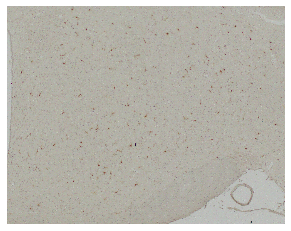

In [4]:
plt.imshow(img, interpolation='nearest')
plt.axis('off')
plt.show()